## Multiclass Classification: MNIST database of handwritten digits
https://keras.io/datasets/

** Dataset Information: **

- Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

** Attribute Information: (784 features and 1 class) **

- 28x28 grayscale images
- 10 digits

** Objective of this project **

- recognizing the digits from images

## Data

In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline  

Using TensorFlow backend.


In [2]:
# Load Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

10608640/11490434 [==========================>...] - ETA: 0s(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


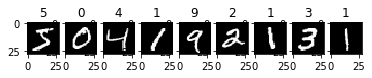

In [3]:
# plot first 9 images
for i in range(0, 9):
    plt.subplot(190 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [4]:
# 10 digits
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

## Baseline MLP

In [5]:
# Data preprocessing
from keras.utils.np_utils import to_categorical
seed = 101 #random seed for reproducibility
np.random.seed(seed)

# flatten 28*28 images to a 784 vector
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [7]:
# Import libraries
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# define the model
def create_model():   
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model
# build the model
model = create_model()
# callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min') #'val_acc'
# train the model
model_history= model.fit(X_train, y_train, validation_data=(X_test, y_test),
                         epochs=50, batch_size=200, verbose=2,
                         callbacks=[early_stop])

# evaluate model on train set
scores = model.evaluate(X_train,y_train,verbose=0)
print('loss of train set: {:0.3f}'.format(scores[0]))
print('accuracy of train set: {:0.1f}%'.format(scores[1]*100))
# evaluate model on test data
scores = model.evaluate(X_test,y_test,verbose=0)
print('loss of test set: {:0.3f}'.format(scores[0]))
print('accuracy of test set: {:0.1f}%'.format(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
1s - loss: 0.2846 - acc: 0.9191 - val_loss: 0.1415 - val_acc: 0.9594
Epoch 2/50
1s - loss: 0.1131 - acc: 0.9678 - val_loss: 0.0969 - val_acc: 0.9720
Epoch 3/50
1s - loss: 0.0718 - acc: 0.9794 - val_loss: 0.0768 - val_acc: 0.9765
Epoch 4/50
1s - loss: 0.0510 - acc: 0.9854 - val_loss: 0.0692 - val_acc: 0.9796
Epoch 5/50
1s - loss: 0.0377 - acc: 0.9891 - val_loss: 0.0627 - val_acc: 0.9796
Epoch 6/50
1s - loss: 0.0273 - acc: 0.9926 - val_loss: 0.0596 - val_acc: 0.98

In [8]:
def plot_model_history(model_history=model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

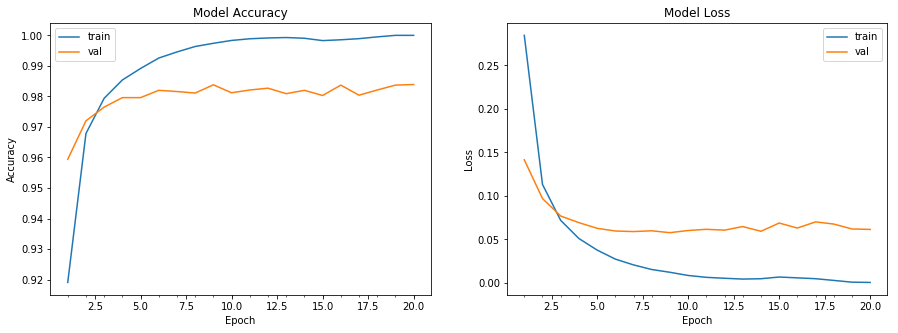

In [9]:
plot_model_history()

## CNN

In [10]:
from keras.utils.np_utils import to_categorical

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Data preprocessing
# reshape to [samples][width][height][pixels]
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [11]:
# Import libraries
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D

K.clear_session()
np.random.seed(seed)

# define the model
def create_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(28, 28,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model
# build the model
model = create_model()
# callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min') #'val_acc'
# train the model
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=50, batch_size=200, verbose=2,
                          callbacks=[early_stop])

# evaluate model on train set
scores = model.evaluate(X_train,y_train,verbose=0)
print('loss of train set: {:0.3f}'.format(scores[0]))
print('accuracy of train set: {:0.1f}%'.format(scores[1]*100))
# evaluate model on test data
scores = model.evaluate(X_test,y_test,verbose=0)
print('loss of test set: {:0.3f}'.format(scores[0]))
print('accuracy of test set: {:0.1f}%'.format(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
__________

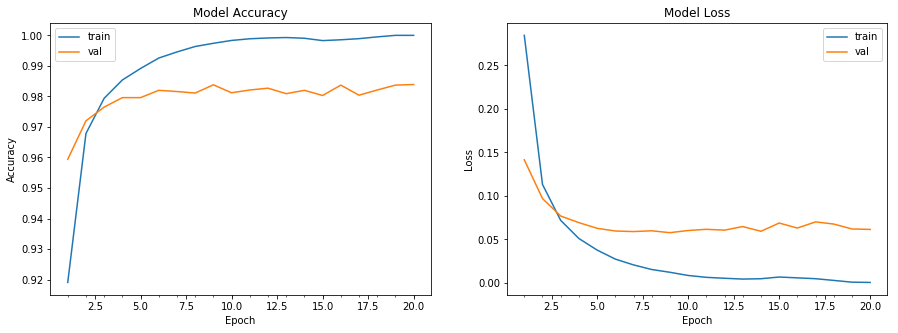

In [12]:
plot_model_history()